# Timing Analysis Pipeline

<b>Description:</b> This pipeline is meant to be part of a three-step process for performing timing analysis on observations of a target time-variable object. The first step of the process was to reduce FITS files of the object by debiasing, dark-subtracting, and flat-fielding. For the pipeline corresponding to the first step, refer to <i>image_reduction_pipeline.ipynb</i>. The second step of the process is to perform aperture photometry on the reduced FITS files and extract the apparent magnitude(s) for the desired object(s). For the pipeline corresponding to the second step, refer to <i>aperture_photometry_pipeline.ipynb</i>. The third step of this process is to perform the timing analysis on the extracted magnitudes themselves. For the pipeline corresponding to the third step, refer to <i>timing_analysis_pipeline.ipynb</i> (this file).

<b>This Jupyter Notebook file will perform the third step of this process: timing analysis of the luminosities of the object(s)</b>. It will take in a text file containing the apparent magnitudes, peak counts values, modified Julian dates, and exposure times for the object(s) and their comparison stars in each FITS file.

<b>Directions:</b> Put in the locations of the files containing the information about the object(s) and comparison stars at the prompted point. In order to customize the plots and data output, edit the cells of the Jupyter Notebook within this file at the prompted points. The prompted points are any place with bolded text. The Jupyter Notebook is meant to be run and edited within the Jupyter Notebook platform itself, instead of being run from the terminal. This decision was made because data analysis is meant to require an active role in exploring the data, rather than being a completely automated process.

<b>Output:</b> A light curve, autocorrelation plot, and a "mean brightness binned by phase" plot with a parameter for the orbital period that the data will be folded over. Each plot can be graphed with or without the ellipsoidal variability subtracted from the data. There is also a parameter you can specify in the plotting functions to save the figure within the directory this Jupyter Notebook file is located in.

<b>IRAF output vs. pipeline output:</b> You may see the phrases "IRAF output" and "pipeline output" being mentioned in this Jupyter Notebook. IRAF output refers to the logfile.txt that is created by IRAF whenever you are rimexam-ing stars. Pipeline output refers to the logfile.txt that is created by the Python file from the previous step of this pipeline, <i>aperture_photometry_pipeline.ipynb</i>, whenever you feed that Python file FITS files to extract the apparent magnitudes of objects.

## Importing Packages and Setting Initial Conditions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math as math
import scipy.optimize
import random
import warnings
import pandas as pd
import sys
from datetime import datetime
from astropy.io import fits
from astropy.time import Time
from scipy import stats
from scipy.optimize import curve_fit
from matplotlib.ticker import AutoMinorLocator

np.set_printoptions(threshold=sys.maxsize)

## Importing A0620 Raw Mags, Compstar Mags, and Peak Count Values From the Logfiles (and then Calculating A0620 True Mags) - also imports MJDs and Exposure Times if using pipeline output

Logfile dictionary that contains the PATHs of all the logfiles, separated by filter and night. 
##### Fill out this dictionary with each filter, each night, and each night's logfile PATH in order to use this pipeline properly.

In [2]:
logfiles_dict = {
    "B": {
                "19Dec2020": "test_dirs_Dec/B-bess/logfile.ecsv",
                "19Mar2021": "test_dirs_Mar/B-bess/logfile.ecsv"
              },
    "I": {
                "19Dec2020": "test_dirs_Dec/I-bess/logfile.ecsv",
                "19Mar2021": "test_dirs_Mar/I-bess/logfile.ecsv",
                "16Apr2021": "test_dirs_Apr/I-bess/logfile.ecsv"
                },
    "V": {
                "19Dec2020": "test_dirs_Dec/V-bess/logfile.ecsv",
                "19Mar2021": "test_dirs_Mar/V-bess/logfile.ecsv",
                "16Apr2021": "test_dirs_Apr/V-bess/logfile.ecsv"
                }
}

'''
# If using logfile output from IRAF, uncomment this code and comment out above code.
logfiles_dict = {
    "B": {
                "19Dec2020": "BVR_band_files/Dec_2020_reduced/Dec_logfile_B.txt",
                "19Mar2021": "BVR_band_files/Mar_2021_reduced/Mar_logfile_B.txt"
              },
    "I": {
                "19Dec2020": "Dec 2020, Mar 2021, and Apr 2021 Dataset\logfile_December_data_only.txt",
                "19Mar2021": "Dec 2020, Mar 2021, and Apr 2021 Dataset\logfile_March_data_only.txt",
                "16Apr2021": "Dec 2020, Mar 2021, and Apr 2021 Dataset\logfile_April_data_only.txt"
                },
    "V": {
                "19Dec2020": "BVR_band_files/Dec_2020_reduced/Dec_logfile_V.txt",
                "19Mar2021": "BVR_band_files/Mar_2021_reduced/Mar_logfile_V.txt",
                "16Apr2021": "BVR_band_files/Apr_2021_reduced/Apr_logfile_V.txt"
                }
}
'''

'\n# If using logfile output from IRAF, uncomment this code and comment out above code.\nlogfiles_dict = {\n    "B": {\n                "19Dec2020": "BVR_band_files/Dec_2020_reduced/Dec_logfile_B.txt",\n                "19Mar2021": "BVR_band_files/Mar_2021_reduced/Mar_logfile_B.txt"\n              },\n    "I": {\n                "19Dec2020": "Dec 2020, Mar 2021, and Apr 2021 Dataset\\logfile_December_data_only.txt",\n                "19Mar2021": "Dec 2020, Mar 2021, and Apr 2021 Dataset\\logfile_March_data_only.txt",\n                "16Apr2021": "Dec 2020, Mar 2021, and Apr 2021 Dataset\\logfile_April_data_only.txt"\n                },\n    "V": {\n                "19Dec2020": "BVR_band_files/Dec_2020_reduced/Dec_logfile_V.txt",\n                "19Mar2021": "BVR_band_files/Mar_2021_reduced/Mar_logfile_V.txt",\n                "16Apr2021": "BVR_band_files/Apr_2021_reduced/Apr_logfile_V.txt"\n                }\n}\n'

Dictionary that contains the absolute magnitudes of each of the comparison stars, separated by filter.
##### Fill out this dictionary with the absolute magnitude of each comparison star for each filter in order to use this pipeline correctly.

In [3]:
abs_compstar_mags_dict = {
    "B": [16.891, 16.383, 15.594, 16.106, 15.481], # Note that this is a placeholder list of absolute magnitudes for now - Prof Bailyn still needs to find the absolute magnitudes of the compstars in the B band
    "I": [16.891, 16.383, 15.594, 16.106, 15.481],
    "V": [16.891, 16.383, 15.594, 16.106, 15.481] # Note that this is a placeholder list of absolute magnitudes for now - Prof Bailyn still needs to find the absolute magnitudes of the compstars in the V band
}

Constructing a dictionary that contains all the raw magnitudes (A0620 and compstar mags combined) and a dictionary that contains all the peak counts values (A0620 and compstar peak counts combined), sorted by bandpass and night.

In [4]:
all_raw_mags_dict = {}
all_peak_counts_dict = {}
for bandpass in list(logfiles_dict.keys()):
    raw_mags_per_night = {}
    peak_counts_per_night = {}
    for night in logfiles_dict[bandpass]:
        raw_mags_per_night[night] = np.loadtxt(logfiles_dict[bandpass][night], dtype=float, skiprows=22, usecols = 3, unpack=True)
        peak_counts_per_night[night] = np.loadtxt(logfiles_dict[bandpass][night], dtype=float, skiprows=22, usecols = 7, unpack=True)
        '''
        # If using logfile output from IRAF, uncomment this code and comment out above code.
        
        raw_mags_per_night[night] = np.loadtxt(logfiles_dict[bandpass][night], dtype=float, usecols = 5, unpack=True)
        peak_counts_per_night_list = list(np.loadtxt(logfiles_dict[bandpass][night], dtype=str, usecols = 8, unpack=True))
        
        # Post-processing of peak_counts: if the peak counts value is INDEF, keep the value as a string. Otherwise, convert the value to a float.
        for i in range(len(peak_counts_per_night_list)):
            if peak_counts_per_night_list[i] != "INDEF":
                peak_counts_per_night_list[i] = float(peak_counts_per_night_list[i])
        peak_counts_per_night[night] = peak_counts_per_night_list
        '''
    all_raw_mags_dict[bandpass] = raw_mags_per_night
    all_peak_counts_dict[bandpass] = peak_counts_per_night

Constructing dictionaries for the true A0620 mags and for each compstar mag, sorted by bandpass and night.

In [5]:
A0620_true_mags_dict = {}
compstar1_mags_dict = {}
compstar2_mags_dict = {}
compstar3_mags_dict = {}
compstar4_mags_dict = {}
compstar5_mags_dict = {}
for bandpass in list(all_raw_mags_dict.keys()):
    A0620_true_mags_per_night = {}
    compstar1_mag_per_night = {}
    compstar2_mag_per_night = {}
    compstar3_mag_per_night = {}
    compstar4_mag_per_night = {}
    compstar5_mag_per_night = {}
    avg_true_abs_mag_compstars_per_filter = np.mean(abs_compstar_mags_dict[bandpass])
    for night in all_raw_mags_dict[bandpass]:
        raw_mags_per_night = all_raw_mags_dict[bandpass][night]
        if len(raw_mags_per_night) % 6 != 0:
            print(f"There's an extra or missing radial profile plot data in {logfiles_dict[bandpass][night]} somewhere. Check your .txt file and examine which .fits file did you not plot all the data for.")
        else:
            A0620_raw_mag_per_night = np.array(raw_mags_per_night[range(0,len(raw_mags_per_night),6)])
            compstar1_mag_per_night[night] = np.array(raw_mags_per_night[range(1,len(raw_mags_per_night),6)])
            compstar2_mag_per_night[night] = np.array(raw_mags_per_night[range(2,len(raw_mags_per_night),6)])
            compstar3_mag_per_night[night] = np.array(raw_mags_per_night[range(3,len(raw_mags_per_night),6)])
            compstar4_mag_per_night[night] = np.array(raw_mags_per_night[range(4,len(raw_mags_per_night),6)])
            compstar5_mag_per_night[night] = np.array(raw_mags_per_night[range(5,len(raw_mags_per_night),6)])
            avg_compstar_mag_per_night = np.round((compstar1_mag_per_night[night] + compstar2_mag_per_night[night] + compstar3_mag_per_night[night] + compstar4_mag_per_night[night] + compstar5_mag_per_night[night])/5, 3)
            differential_mag_per_night = A0620_raw_mag_per_night - avg_compstar_mag_per_night
            A0620_true_mag_per_night = np.round(differential_mag_per_night + avg_true_abs_mag_compstars_per_filter, 3)
        A0620_true_mags_per_night[night] = A0620_true_mag_per_night
    A0620_true_mags_dict[bandpass] = A0620_true_mags_per_night
    compstar1_mags_dict[bandpass] = compstar1_mag_per_night
    compstar2_mags_dict[bandpass] = compstar2_mag_per_night
    compstar3_mags_dict[bandpass] = compstar3_mag_per_night
    compstar4_mags_dict[bandpass] = compstar4_mag_per_night
    compstar5_mags_dict[bandpass] = compstar5_mag_per_night

Defining a function that will find the true magnitudes for each comparison star.

In [6]:
def find_true_compstar_mag(compstar_num, bandpass, night, compstar_dicts):
    compstar_mags = compstar_dicts[compstar_num][bandpass][night]
    true_compstar_mags = []
    for i in range(len(compstar_mags)):
        all_compstar_mags = []
        for j in range(len(compstar_dicts)):
            if j != compstar_num:
                all_compstar_mags.append(compstar_dicts[j][bandpass][night][i])
        avg_compstar_mag = round(np.mean(all_compstar_mags), 3)
        #The magnitude is always at maximum two decimal places out, so the sum of these magnitudes will always be at maximum
        #  two decimal places out. Therefore, when I divide the sum by 5, I should get a quotient that is at maximum three
        #  decimal places out. This step is necessary because Python can do the math for floating point numbers kind of weird.
        differential_mag = np.subtract(compstar_mags[i], avg_compstar_mag)
        
        all_true_compstar_mags = abs_compstar_mags_dict[bandpass].copy()
        all_true_compstar_mags.pop(compstar_num)
        avg_true_mag_compstars = np.mean(all_true_compstar_mags)
        
        true_compstar_mags.append(round(differential_mag + avg_true_mag_compstars, 3))
        #Once again, Python treats addition of floating number points weirdly, so I use the round function again.
    return np.array(true_compstar_mags)

Constructing dictionaries for true magnitudes of each comparison star, sorted by bandpass and night. 

In [7]:
compstar_mags_dicts = [compstar1_mags_dict, compstar2_mags_dict, compstar3_mags_dict, compstar4_mags_dict, compstar5_mags_dict]
compstar1_true_mags_dict = {}
compstar2_true_mags_dict = {}
compstar3_true_mags_dict = {}
compstar4_true_mags_dict = {}
compstar5_true_mags_dict = {}
compstar_true_mags_dicts = [compstar1_true_mags_dict, compstar2_true_mags_dict, compstar3_true_mags_dict, compstar4_true_mags_dict, compstar5_true_mags_dict]

for i in range(len(compstar_mags_dicts)):
    for bandpass in list(compstar_mags_dicts[i].keys()):
        compstar_true_mag_per_night = {}
        for night in compstar1_mags_dict[bandpass]:
            compstar_true_mag_per_night[night] = find_true_compstar_mag(i, bandpass, night, compstar_mags_dicts)
        compstar_true_mags_dicts[i][bandpass] = compstar_true_mag_per_night

Constructing dictionaries for A0620 peak counts values and for each compstar peak counts values, sorted by bandpass and night.

In [8]:
A0620_peaks_dict = {}
compstar1_peaks_dict = {}
compstar2_peaks_dict = {}
compstar3_peaks_dict = {}
compstar4_peaks_dict = {}
compstar5_peaks_dict = {}
for bandpass in list(all_peak_counts_dict.keys()):
    A0620_peaks_per_night = {}
    compstar1_peaks_per_night = {}
    compstar2_peaks_per_night = {}
    compstar3_peaks_per_night = {}
    compstar4_peaks_per_night = {}
    compstar5_peaks_per_night = {}
    for night in all_peak_counts_dict[bandpass]:
        peaks_per_night = all_peak_counts_dict[bandpass][night]
        if len(peaks_per_night) % 6 != 0:
            print(f"There's an extra or missing radial profile plot data in {logfiles_dict[bandpass][night]} somewhere. Check your .txt file and examine which .fits file did you not plot all the data for.")
        else:
            A0620_peaks_per_night[night] = np.array(peaks_per_night, dtype='object')[range(0,len(peaks_per_night),6)]
            compstar1_peaks_per_night[night] = np.array(peaks_per_night, dtype='object')[range(1,len(peaks_per_night),6)]
            compstar2_peaks_per_night[night] = np.array(peaks_per_night, dtype='object')[range(2,len(peaks_per_night),6)]
            compstar3_peaks_per_night[night] = np.array(peaks_per_night, dtype='object')[range(3,len(peaks_per_night),6)]
            compstar4_peaks_per_night[night] = np.array(peaks_per_night, dtype='object')[range(4,len(peaks_per_night),6)]
            compstar5_peaks_per_night[night] = np.array(peaks_per_night, dtype='object')[range(5,len(peaks_per_night),6)]
    A0620_peaks_dict[bandpass] = A0620_peaks_per_night
    compstar1_peaks_dict[bandpass] = compstar1_peaks_per_night
    compstar2_peaks_dict[bandpass] = compstar2_peaks_per_night
    compstar3_peaks_dict[bandpass] = compstar3_peaks_per_night
    compstar4_peaks_dict[bandpass] = compstar4_peaks_per_night
    compstar5_peaks_dict[bandpass] = compstar5_peaks_per_night

Constructing dictionaries that contains the Modified Julian Date and exposure time of each fits file organized by bandpass and night. <b>(Comment out this code if using IRAF output instead of pipeline output).</b>

In [9]:
MJD_dict = {}
exptime_dict = {}

for bandpass in list(logfiles_dict.keys()):
    MJDs_per_night = {}
    exptimes_per_night = {}
    for night in logfiles_dict[bandpass]:
        MJDs = np.loadtxt(logfiles_dict[bandpass][night], dtype=float, skiprows=22, usecols = 9, unpack=True)
        exptimes = np.loadtxt(logfiles_dict[bandpass][night], dtype=float, skiprows=22, usecols = 10, unpack=True)
        IDs = np.loadtxt(logfiles_dict[bandpass][night], dtype=int, skiprows=22, usecols = 6, unpack=True)
        num_objects = max(IDs)
        MJD_list = []
        exptime_list = []
        [MJD_list.append(MJDs[i]) for i in range(0,len(MJDs),num_objects)]
        [exptime_list.append(exptimes[i]) for i in range(0,len(exptimes),num_objects)]
        MJDs_per_night[night] = MJD_list
        exptimes_per_night[night] = exptime_list
    MJD_dict[bandpass] = MJDs_per_night
    exptime_dict[bandpass] = exptimes_per_night

## Importing Filenames, MJDs, and Exposure Times from Directories with Processed Fits Files (and then Calculating Modified Times) - only necessary if using IRAF output

Fits file dictionary that contains the PATHs of all the directories containing the processed fits files, separated by filter and night.
##### If using IRAF output, fill out this dictionary with each filter, each night, and each fits file directory PATH in order to use this pipeline properly.

In [10]:
'''
# If using logfile output from IRAF, uncomment this code and comment out above code.
fits_dict = {
    "B": {
            "19Dec2020": "test_dirs_Dec/B-bess",
            "19Mar2021": "test_dirs_Mar/B-bess"
            },
    "I": {
            "19Dec2020": "test_dirs_Dec/I-bess",
            "19Mar2021": "test_dirs_Mar/I-bess",
            "16Apr2021": "test_dirs_Apr/I-bess"
            },
    "V": {
            "19Dec2020": "test_dirs_Dec/V-bess",
            "19Mar2021": "test_dirs_Mar/V-bess",
            "16Apr2021": "test_dirs_Apr/V-bess"
            }
}
'''

'\n# If using logfile output from IRAF, uncomment this code and comment out above code.\nfits_dict = {\n    "B": {\n            "19Dec2020": "test_dirs_Dec/B-bess",\n            "19Mar2021": "test_dirs_Mar/B-bess"\n            },\n    "I": {\n            "19Dec2020": "test_dirs_Dec/I-bess",\n            "19Mar2021": "test_dirs_Mar/I-bess",\n            "16Apr2021": "test_dirs_Apr/I-bess"\n            },\n    "V": {\n            "19Dec2020": "test_dirs_Dec/V-bess",\n            "19Mar2021": "test_dirs_Mar/V-bess",\n            "16Apr2021": "test_dirs_Apr/V-bess"\n            }\n}\n'

Constructing dictionaries that contains the Modified Julian Date and exposure time of each fits file organized by filter, night, and filename.

In [11]:
'''
# If using logfile output from IRAF, uncomment this code and comment out above code.
MJD_dict = {}
exptime_dict = {}
for bandpass in list(fits_dict.keys()):
    MJD_per_bandpass_data = {}
    exptime_per_bandpass_data = {}
    for night in fits_dict[bandpass]:
        MJD_per_night_data = {}
        exptime_per_night_data = {}
        fits_filenames = os.listdir(fits_dict[bandpass][night])
        for filename in fits_filenames:
            with fits.open(f"{fits_dict[bandpass][night]}/{filename}") as hdu:
                UTCSTART = hdu[0].header["UTCSTART"]
                MJD = Time(UTCSTART, format="isot", scale="utc").mjd
                exptime = hdu[0].header["EXPTIME"]
            MJD_per_night_data[filename] = MJD
            exptime_per_night_data[filename] = exptime
        MJD_per_bandpass_data[night] = MJD_per_night_data
        exptime_per_bandpass_data[night] = exptime_per_night_data
    MJD_dict[bandpass] = MJD_per_bandpass_data
    exptime_dict[bandpass] = exptime_per_bandpass_data
'''

'\n# If using logfile output from IRAF, uncomment this code and comment out above code.\nMJD_dict = {}\nexptime_dict = {}\nfor bandpass in list(fits_dict.keys()):\n    MJD_per_bandpass_data = {}\n    exptime_per_bandpass_data = {}\n    for night in fits_dict[bandpass]:\n        MJD_per_night_data = {}\n        exptime_per_night_data = {}\n        fits_filenames = os.listdir(fits_dict[bandpass][night])\n        for filename in fits_filenames:\n            with fits.open(f"{fits_dict[bandpass][night]}/{filename}") as hdu:\n                UTCSTART = hdu[0].header["UTCSTART"]\n                MJD = Time(UTCSTART, format="isot", scale="utc").mjd\n                exptime = hdu[0].header["EXPTIME"]\n            MJD_per_night_data[filename] = MJD\n            exptime_per_night_data[filename] = exptime\n        MJD_per_bandpass_data[night] = MJD_per_night_data\n        exptime_per_bandpass_data[night] = exptime_per_night_data\n    MJD_dict[bandpass] = MJD_per_bandpass_data\n    exptime_dict[ba

## Manually Entering in Data to the Dictionaries

##### If you have data that doesn't follow the formatting of the automatic processors for entering in data to the magnitudes, peak counts values, MJD, and exposure time dictionaries, then use the below cell to code in the data entry of your data to these existing dictionaries.

In [12]:
# Example code: entering in data for observations of A0620-00 from 2001 to 2019, spaced a night apart.
#   This data only has the true A0620-00 mags and the JD of these observations, formatted in a .txt file,
#   so we can only add this data to A0620_true_mags_dict and MJD_dict.

def convert_JD_to_MJD(JDs):
    return JDs - 2400000.5

PATH = "Historical Dataset (2001 to 2019)/A0620_SMARTS_I.txt"
historical_mags, historical_JDs = np.loadtxt(PATH, usecols=(1,2), skiprows=1, unpack=True)
A0620_true_mags_dict["I"]["2001 to 2019"] = historical_mags
historical_MJDs = convert_JD_to_MJD(historical_JDs)
'''
# If using logfile output from IRAF, uncomment this code and comment out above code.
for i in range(len(historical_JDs)):
    historical_MJDs[f"A0620_SMARTS_I.txt line {i}"] = convert_JD_to_MJD(historical_JDs[i])
'''
MJD_dict["I"]["2001 to 2019"] = historical_MJDs

## Filling Out Phases Dictionaries

Calculate the length of orbit (in units of days) for a specific night for an object whose orbital period changes over time.
##### If the object's orbital period changes over time, edit the below cell in order to determine the orbital period of your object at a specific date.

In [13]:
# Input specified date, reference date, orbital period for the reference date, and the change in orbital period per day
date = '2023/1/16' # Jan 16 2023
date_ref = '2021/4/16' # Apr 16 2021
orbital_period_ref = 0.32301389 # in units of days
rate = -1.9e-11 # in units of days/days

# Difference between datetime in days
d = datetime.strptime(date, "%Y/%m/%d")
d_ref = datetime.strptime(date_ref, "%Y/%m/%d")
delta = d - d_ref
delta = float(delta.days)

# Calculating the orbital period for the specified night
orbital_period = '%.8f'%(orbital_period_ref + delta*rate)
print(f"The orbital period of the object on {date} is {orbital_period} days.")

The orbital period of the object on 2023/1/16 is 0.32301388 days.


Dictionary that contains the length of orbit (in units of days) for each night.
##### Fill out this dictionary with the orbital period of the object on each night in order to use this pipeline properly.

In [14]:
orbital_period_dict = {
    "2001 to 2019": 0.32301398,
    "19Dec2020": 0.32301389,
    "19Mar2021": 0.32301389,
    "16Apr2021": 0.32301389
                             }
# units of days

Dictionary that contains the orbital phase of each observation, sorted by bandpass and night.

In [15]:
orbital_phases_dict = {}
for bandpass in list(MJD_dict.keys()):
    orbital_phase_per_bandpass = {}
    for night in list(MJD_dict[bandpass].keys()):
        orbital_phase_per_night = []
        for MJD in list(MJD_dict[bandpass][night]):
            orbital_phase = (MJD/orbital_period_dict[night]) - (MJD/orbital_period_dict[night]).astype(int)
            orbital_phase_per_night.append(orbital_phase)
        orbital_phase_per_bandpass[night] = orbital_phase_per_night
    orbital_phases_dict[bandpass] = orbital_phase_per_bandpass

## Subtracting Ellipsoidal Variation from the Light Curves

Defining the functions that will remove the ellipsoidal variation from any light curve, given a reference light curve (the reference light curve can be the same light curve as the light curve you are trying to subtract ellipsoidal variation off of).

In [16]:
def compute_optimal_bin_number(dataset):
    '''Computes the optimal number of bins to use for
       a dataset using the Freedman-Diaconis rule.'''
    IQR = scipy.stats.iqr(dataset)
    n = len(dataset)
    h = 2 * IQR * (n**(-1/3))
    num_bins = (max(dataset) - min(dataset)) / h
    return math.floor(num_bins)

In [17]:
def remove_ellipsoidal_contribution(light_curve_minuend, light_curve_subtrahend, plot=False):
    '''Removes the ellipsoidal component for all the light curves in light_curve_minuend
        (which originates from the companion star) by using a binning method to find the ellipsoidal curve, 
        and then subtracting each point the light curves in light_curve_minuend by the ellipsoidal curve.
       Returns a list of the new magnitudes with the ellipsoidal contribution removed
        (i.e. the accretion flow light curve(s)).'''
    # Calculates the ellipsoidal curve to subtract off using the subtrahend light curve.
    subtrahend_bandpass, subtrahend_night = light_curve_subtrahend
    subtrahend_mags = A0620_true_mags_dict[subtrahend_bandpass][subtrahend_night]
    subtrahend_phases = orbital_phases_dict[subtrahend_bandpass][subtrahend_night]
    num_bins = compute_optimal_bin_number(subtrahend_mags)
    bins = np.linspace(min(subtrahend_phases),max(subtrahend_phases),num_bins)
    mean_binned_mags = [] # A list of the mean magnitude in each bin
    for i in range(len(bins)-1):
        phase_indices = np.where((subtrahend_phases >= bins[i]) & (subtrahend_phases < bins[i+1]+(10**-15)))[0]
        subtrahend_mags_at_that_bin = subtrahend_mags[phase_indices]
        mean_binned_mags.append(np.nanmean(subtrahend_mags_at_that_bin))
    
    # Subtracts off the ellipsoidal variation from the minuend light curves
    if np.array(light_curve_minuend).ndim == 1:
        minuend_bandpass, minuend_night = light_curve_minuend
        minuend_mags = A0620_true_mags_dict[minuend_bandpass][minuend_night]
        minuend_phases = orbital_phases_dict[minuend_bandpass][minuend_night]
        accretion_flow_mags = np.zeros(len(minuend_mags))
        for i in range(len(bins)-1):
            phase_indices = np.where((minuend_phases >= bins[i]) & (minuend_phases < bins[i+1]+(10**-15)))[0]
            accretion_flow_mags[phase_indices] = minuend_mags[phase_indices] - mean_binned_mags[i]
            
        if plot:
            duplicated_minuend_phases = np.append(minuend_phases, [x + 1 for x in minuend_phases])
            duplicated_minuend_mags = np.append(minuend_mags, minuend_mags)
            duplicated_accretion_flow_mags = np.append(accretion_flow_mags, accretion_flow_mags)
            duplicated_bins = np.append(bins[:-1], bins[:-1])
            duplicated_mean_binned_mags = np.append(mean_binned_mags, mean_binned_mags)
            fig = plt.figure(figsize=(15,10))
            minuend_ax = fig.add_subplot(2, 1, 1)
            minuend_ax.plot(duplicated_minuend_phases, duplicated_minuend_mags, 'bo', label="Minuend Light Curve")
            minuend_ax.plot(duplicated_bins, duplicated_mean_binned_mags, 'ro', label="Ellipsoidal Light Curve Points")
            minuend_ax.set_xlim(0.0, 2.0)
            minuend_ax.set_xlabel("Minuend Orbital Phase")
            minuend_ax.set_ylabel("Absolute Magnitude")
            minuend_ax.set_title(f"{minuend_bandpass} Band Light Curve Before Ellipsoidal Variation Subtraction")
            minuend_ax.legend()
            accretion_flow_ax = fig.add_subplot(2, 1, 2)
            accretion_flow_ax.plot(duplicated_minuend_phases, duplicated_accretion_flow_mags, 'go', label="Accretion Flow Light Curve")
            accretion_flow_ax.set_xlim(0.0, 2.0)
            accretion_flow_ax.set_xlabel("Minuend Orbital Phase")
            accretion_flow_ax.set_ylabel("Relative Magnitude")
            accretion_flow_ax.set_title(f"{minuend_bandpass} Band Light Curve After Ellipsoidal Variation Subtraction")
            accretion_flow_ax.legend()
        accretion_flow_mags_dict[minuend_bandpass] = {minuend_night: accretion_flow_mags}
        
    if np.array(light_curve_minuend).ndim == 2:
        if plot: fig = plt.figure(figsize=(15,10*len(light_curve_minuend)))
        for i in range(len(light_curve_minuend)):
            minuend_bandpass, minuend_night = light_curve_minuend[i]
            minuend_mags = A0620_true_mags_dict[minuend_bandpass][minuend_night]
            minuend_phases = orbital_phases_dict[minuend_bandpass][minuend_night]
            accretion_flow_mags = np.zeros(len(minuend_phases))
            for j in range(len(bins)-1):
                phase_indices = np.where((minuend_phases >= bins[j]) & (minuend_phases < bins[j+1]+(10**-15)))[0]
                accretion_flow_mags[phase_indices] = minuend_mags[phase_indices] - mean_binned_mags[j]
            if minuend_bandpass in accretion_flow_mags_dict.keys():
                accretion_flow_mags_dict[minuend_bandpass][minuend_night] = accretion_flow_mags
            else:
                accretion_flow_mags_dict[minuend_bandpass] = {minuend_night : accretion_flow_mags}
            if plot:
                duplicated_minuend_phases = np.append(minuend_phases, [x + 1 for x in minuend_phases])
                duplicated_minuend_mags = np.append(minuend_mags, minuend_mags)
                duplicated_accretion_flow_mags = np.append(accretion_flow_mags, accretion_flow_mags)
                duplicated_bins = np.append(bins[:-1], bins[:-1]+1)
                duplicated_mean_binned_mags = np.append(mean_binned_mags, mean_binned_mags)
                minuend_ax = fig.add_subplot(len(light_curve_minuend)*2, 1, i*2 + 1)
                minuend_ax.plot(duplicated_minuend_phases, duplicated_minuend_mags, 'bo', label="Minuend Light Curve")
                minuend_ax.plot(duplicated_bins, duplicated_mean_binned_mags, 'ro', label="Ellipsoidal Light Curve Points")
                minuend_ax.set_xlim(0.0, 2.0)
                minuend_ax.set_xlabel("Minuend Orbital Phase")
                minuend_ax.set_ylabel("Absolute Magnitude")
                minuend_ax.set_title(f"{minuend_bandpass} Band Light Curve on {minuend_night} Before Ellipsoidal Variation Subtraction")
                minuend_ax.legend()
                accretion_flow_ax = fig.add_subplot(len(light_curve_minuend)*2, 1, i*2 + 2)
                accretion_flow_ax.plot(duplicated_minuend_phases, duplicated_accretion_flow_mags, 'go', label="Accretion Flow Light Curve")
                accretion_flow_ax.set_xlim(0.0, 2.0)
                accretion_flow_ax.set_xlabel("Minuend Orbital Phase")
                accretion_flow_ax.set_ylabel("Relative Magnitude")
                accretion_flow_ax.set_title(f"{minuend_bandpass} Band Light Curve on {minuend_night} After Ellipsoidal Variation Subtraction")
                accretion_flow_ax.legend()
        if plot: plt.show()

The below block of code will automatically fill in a dictionary containing the accretion flow magnitudes of each light curve (sorted by bandpass and night) <b>accretion_flow_mags_dict</b> for the given minuend light curves that you input into the remove_ellipsoidal_contribution function.
<br>To use the <b>remove_ellipsoidal_contribution</b> function, you need to pass in the following parameters:
<ul>
    <li><b>minuend_light_curves</b>: A list containing the light curves you want to subtract ellipsoidal variation off of. The list must be formatted as [bandpass, night], and the bandpass and night must be able to be found within both the A0620_true_mags_dict and the MJD_dict. This parameter can either be a 1D array containing only the bandpass and night for one light curve, or it can be a 2D array containing a list of the bandpasses and nights corresponding to the light curves you want to subtract ellipsoidal variation off of.</li>
    <li><b>subtrahend_light_curve</b>: A list containing the bandpass and night for the reference light curve that you want to use as the subtractor in the removing ellipsoidal variation procedure. The bandpass and night must be able to be found within both the A0620_true_mags_dict and the MJD_dict. This parameter can only be a 1D array; it cannot be formatted as a 2D array.</li>
    <li><b>plot</b>: A boolean for whether you want to plot the light curves before and after the ellipsoidal variation subtraction procedure. Default is False.</li>
</ul>
For reference, the minuend, subtrahend, and difference are parts of a subtraction problem. For example, in the subtraction problem, 7 – 3 = 4, the number 7 is the minuend, the number 3 is the subtrahend and the number 4 is the difference.
<br><b><i>Fill out the minuend_light_curves and subtrahend_light_curves dictionaries according to which nights you want to be the subtracted and which night(s) you want to be the subtratees.</i></b>

In [18]:
accretion_flow_mags_dict = {}

minuend_light_curves = [["B", "19Dec2020"],
                        ["V", "19Dec2020"],
                        ["I", "19Dec2020"],
                        ["I", "19Mar2021"],
                        ["I", "16Apr2021"],
                        ["I", "2001 to 2019"]]
subtrahend_light_curve = ["I", "2001 to 2019"]
remove_ellipsoidal_contribution(minuend_light_curves, subtrahend_light_curve, plot=False)

## Finding Comparison Stars to Use in Calculating Error Assigning Equation for Each Data Point

The below function prints the difference between the pairwise mean magnitude of A0620-00 and the mean magnitudes of the comparison stars for a given bandpass. The comparison stars whose mean magnitude is closest to the mean magnitude of A0620-00 are the comparison stars that you should use when determining the best-fit line for the error assigning equation for A0620-00's peak counts values in that bandpass. (Use your judgement when determining how "close" a comparison star's brightness to A0620-00 should be in order to include in the calculation of the error assigning equation.)
<br>Parameters:
<ul>
    <li><b>bandpass</b>: A string containing the bandpass for which you want to calculate the pairwise difference in mean magnitudes between A0620-00 and the comparison stars. Must be a key found within the A0620_true_mags_dict and all the compstar_mag dictionaries.</li>
    <li><b>excluded_nights</b>: A list of the nights that you want to exclude from the calculation. Use this if you want to exclude a certain night from the calculation, either for quality control reasons or because the night cannot be found within all the compstar_mag dictionaries. The night must be able to be found within the A0620_true_mags_dict. Default is an empty list.</li>
</ul>

In [19]:
def difference_between_means_of_mags(bandpass, excluded_nights = []):
    '''Prints the pairwise difference between the mean magnitude of A0620-00 and the mean magnitudes
        of all the comparison stars. Excludes the data in the nights in the excluded_nights parameter 
        from the calculation of these mean magnitudes.'''
    A0620_mags = np.array([])
    compstar1_mags = np.array([])
    compstar2_mags = np.array([])
    compstar3_mags = np.array([])
    compstar4_mags = np.array([])
    compstar5_mags = np.array([])
    for night in list(A0620_true_mags_dict[bandpass].keys()):
        if not night in excluded_nights:
            A0620_mags = np.concatenate((A0620_mags, A0620_true_mags_dict[bandpass][night]))
            compstar1_mags = np.concatenate((compstar1_mags, compstar1_mags_dict[bandpass][night]))
            compstar2_mags = np.concatenate((compstar2_mags, compstar2_mags_dict[bandpass][night]))
            compstar3_mags = np.concatenate((compstar3_mags, compstar3_mags_dict[bandpass][night]))
            compstar4_mags = np.concatenate((compstar4_mags, compstar4_mags_dict[bandpass][night]))
            compstar5_mags = np.concatenate((compstar5_mags, compstar5_mags_dict[bandpass][night]))
    print(f"Difference between mean of A0620-00 magnitude and mean of compstar1 magnitude: {abs(np.mean(A0620_mags) - np.mean(compstar1_mags))}")
    print(f"Difference between mean of A0620-00 magnitude and mean of compstar2 magnitude: {abs(np.mean(A0620_mags) - np.mean(compstar2_mags))}")
    print(f"Difference between mean of A0620-00 magnitude and mean of compstar3 magnitude: {abs(np.mean(A0620_mags) - np.mean(compstar3_mags))}")
    print(f"Difference between mean of A0620-00 magnitude and mean of compstar4 magnitude: {abs(np.mean(A0620_mags) - np.mean(compstar4_mags))}")
    print(f"Difference between mean of A0620-00 magnitude and mean of compstar5 magnitude: {abs(np.mean(A0620_mags) - np.mean(compstar5_mags))}")

In [20]:
difference_between_means_of_mags("B")

Difference between mean of A0620-00 magnitude and mean of compstar1 magnitude: 0.8301068785702874
Difference between mean of A0620-00 magnitude and mean of compstar2 magnitude: 1.570602395863041
Difference between mean of A0620-00 magnitude and mean of compstar3 magnitude: 2.965639265435046
Difference between mean of A0620-00 magnitude and mean of compstar4 magnitude: 1.541209243967561
Difference between mean of A0620-00 magnitude and mean of compstar5 magnitude: 2.399160498655071


<i>Given that compstar1, compstar2, and compstar4 have the closest mean magnitude to that of A0620-00, those three comparison stars should be used when calculating the error assigning equation for the B bandpass.</i>

In [21]:
difference_between_means_of_mags("V")

Difference between mean of A0620-00 magnitude and mean of compstar1 magnitude: 1.2491650523055444
Difference between mean of A0620-00 magnitude and mean of compstar2 magnitude: 1.8831641463842406
Difference between mean of A0620-00 magnitude and mean of compstar3 magnitude: 3.0213901327538544
Difference between mean of A0620-00 magnitude and mean of compstar4 magnitude: 1.9575402556272987
Difference between mean of A0620-00 magnitude and mean of compstar5 magnitude: 2.75907770903628


<i>Given that compstar1, compstar2, and compstar4 have the closest mean magnitude to that of A0620-00, those three comparison stars should be used when calculating the error assigning equation for the V bandpass.</i>

In [22]:
difference_between_means_of_mags("I", excluded_nights = ["2001 to 2019"])

Difference between mean of A0620-00 magnitude and mean of compstar1 magnitude: 1.0563622932872008
Difference between mean of A0620-00 magnitude and mean of compstar2 magnitude: 1.5615035275216336
Difference between mean of A0620-00 magnitude and mean of compstar3 magnitude: 2.331978036043944
Difference between mean of A0620-00 magnitude and mean of compstar4 magnitude: 1.8313710627179045
Difference between mean of A0620-00 magnitude and mean of compstar5 magnitude: 2.446172883175482


<i>Given that compstar1, compstar2, and compstar4 have the closest mean magnitude to that of A0620-00, those three comparison stars should be used when calculating the error assigning equation for the I bandpass.</i>

## Calculating the Error Assigning Equation

The below function fits a linear relationship between the peak counts and the measurement error for a specific bandpass. This is necessary because each frame has a different amount of error, and each bandpass has a difference relationship between peak counts and measurement error. We will use this frame-by-frame measurement error as our definition of error for our brightness values of A0620-00.
<br>Parameters:
<ul>
    <li><b>bandpass</b>: A string containing the bandpass for which you want to calculate the fit between peak counts and measurement error. Must be a key found within the A0620_peaks_dict and all the compstar_mag dictionaries.</li>
    <li><b>compstars_to_use</b>: A list containing the IDs of the comparison stars you want to use when calculating the fit between peak counts and measurement error. For example, if you want to use comparison stars 1, 2, and 4 for calculating the fit, input [1,2,4] for this parameter.
    <li><b>excluded_nights</b>: A list of the nights that you want to exclude from the calculation. Use this if you want to exclude a certain night from the calculation, either for quality control reasons or because the night cannot be found within all the compstar_mag dictionaries. The night must be able to be found within the A0620_true_mags_dict. Default is an empty list.</li>
    <li><b>excluded_peaks_ranges</b>: A nx2 list of the peak ranges you want to exclude when calculating the fit. Each row in the list contains [lower_lim, upper_lim] as the peak range to exclude. Useful if one particular range of peak counts gives a measurement error that is an outlier and messes with the linear fit. Default is an empty list.
    <li><b>include_residuals</b>: A boolean for whether you want to display a graph of the fit residuals or not. Default is False.
</ul>

In [27]:
def plt_error_vs_peak_counts_value(bandpass, compstars_to_use, excluded_nights = [], excluded_peaks_ranges = [], include_residuals = False):
    '''Plots a graph of measurement error versus peak counts value for a given bandpass and
        returns the coefficients of the linear fit in descending order.
        Excludes the data in the nights in the excluded_nights parameter from the calculation
        of the error assigning equation.'''    
    # Flattening all the peak counts values into a 1D array (for A0620_peaks) or a 2D array containing each of the compstars' magnitudes (for compstars_mags)
    A0620_peaks = []
    all_compstars_mags = []
    for night in list(A0620_peaks_dict[bandpass].keys()):
        if not night in excluded_nights:
            A0620_peaks = np.concatenate((A0620_peaks, A0620_peaks_dict[bandpass][night]))
    for compstar in compstars_to_use:
        single_compstar_mags = []
        for night in list(A0620_peaks_dict[bandpass].keys()):
            if not night in excluded_nights:
                single_compstar_mags = np.concatenate((single_compstar_mags, compstar_true_mags_dicts[compstar-1][bandpass][night])) # We need to index by compstar-1 because Python lists use zero-based indexing but our labeling of compstars use one-based indexing
        all_compstars_mags.append(single_compstar_mags)
    for excluded_peaks_range in excluded_peaks_ranges:
        lower_lim, upper_lim = excluded_peaks_range
        excluded_indices = np.where((A0620_peaks >= lower_lim) & (A0620_peaks <= upper_lim))[0]
        A0620_peaks = np.delete(A0620_peaks, excluded_indices)
        for i in range(len(all_compstars_mags)):
            all_compstars_mags[i] = np.delete(all_compstars_mags[i], excluded_indices)
        
    # Calculates the measurement error for each bin of peak counts values
    num_bins = compute_optimal_bin_number(A0620_peaks)
    bins = np.linspace(min(A0620_peaks), max(A0620_peaks), num_bins)
    errors = []
    average_peak_counts = []
    bins_with_data = []
    for i in range(num_bins-1):
        indices_in_bin = np.where((A0620_peaks >= bins[i]) & (A0620_peaks < bins[i+1] + (10**-14)))[0]
        std_of_compstars_mag_in_bin = []
        for single_compstar_mags in all_compstars_mags:
            if len(single_compstar_mags[indices_in_bin]) > 1:
                std_of_compstars_mag_in_bin.append(np.std(single_compstar_mags[indices_in_bin]))
        if std_of_compstars_mag_in_bin == []:
            break
        mean_of_stds_in_bin = np.nanmean(std_of_compstars_mag_in_bin)
        errors.append(mean_of_stds_in_bin)
        bins_with_data.append([bins[i],bins[i+1]])
        
    # Plots the measurement error vs peak counts graph
    x_axis_values = []
    for i in range(len(bins_with_data)):
        x_axis_values.append((bins_with_data[i][0]+bins_with_data[i][1])/2)
    
    def linear_regression(x, a, b):
        y = a*x + b
        return y
    
    fig = plt.figure(figsize=(20,5))
    ax = fig.add_subplot()
    popt, pcov = curve_fit(linear_regression, x_axis_values, errors)
    slope, intercept = popt[0], popt[1]
    ax.plot(x_axis_values, errors, 'bo')
    predicted_line = slope * np.array(x_axis_values) + intercept
    ax.plot(x_axis_values, predicted_line, 'r--',label="Line of Best Fit")
    ax.set_xlabel("Midpoint of Peak Counts Value Bin")
    ax.set_ylabel("Error in Bin of Peak Counts Value")
    ax.set_title(f"Error for each Peak Counts Value\n$R^2$: y= {round(slope, 5)}*x + {round(intercept, 5)}")
    ax.legend()
    plt.show()
    
    # Plots the residuals graph
    if include_residuals:
        residuals_list = []
        for i in range(len(errors)):
            residuals_list.append(predicted_line[i] - errors[i])
        fig2 = plt.figure(figsize=(20,5))
        ax2 = fig2.add_subplot()
        ax2.plot(errors, residuals_list, 'bo')
        ax2.set_title("Fitted Value vs. Residuals")
        ax2.set_xlabel("Fitted Value")
        ax2.set_ylabel("Residuals")
        
    return slope, intercept

<b>Run the below cells to determine the fitted slope and error for each bandpass.</b>

[17.214 17.204 17.201 17.208]
[16.39  16.405 16.355 16.42 ]
[16.474 16.491 16.504 16.396]
[17.252 17.172 17.202 17.177 17.242 17.152 17.161 17.221 17.216 17.226
 17.168 17.178 17.174]
[16.383 16.403 16.394 16.39  16.374 16.378 16.39  16.381 16.354 16.34
 16.365 16.367 16.409]
[16.483 16.505 16.502 16.472 16.466 16.447 16.491 16.478 16.491 16.491
 16.508 16.507 16.517]
[17.203 17.187 17.211 17.163 17.129 17.17  17.223 17.15  17.19  17.242
 17.216 17.219 17.163 16.949]
[16.377 16.388 16.395 16.43  16.396 16.377 16.38  16.419 16.362 16.354
 16.348 16.368 16.418 16.327]
[16.505 16.507 16.494 16.507 16.514 16.481 16.475 16.425 16.463 16.495
 16.51  16.503 16.5   16.488]
[17.185 17.198 17.067 17.077 17.196 17.217 17.192 17.203]
[16.38  16.397 16.401 16.424 16.344 16.369 16.355 16.379]
[16.514 16.476 16.404 16.427 16.5   16.496 16.485 16.519]


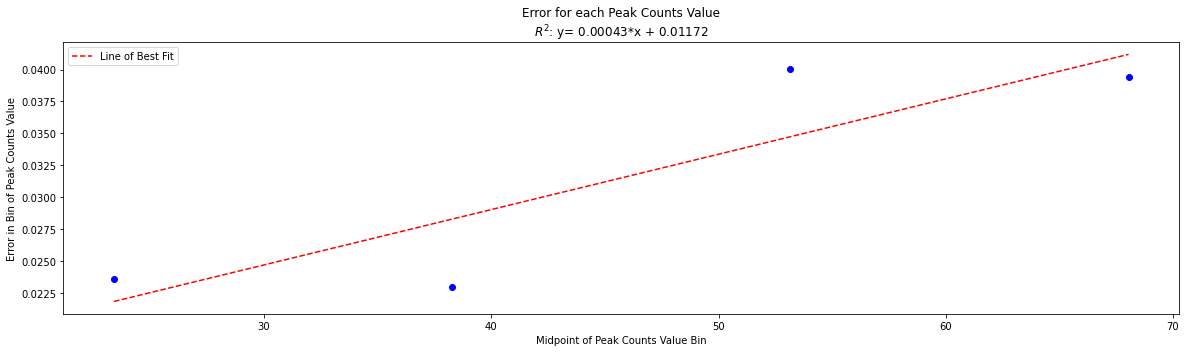

In [28]:
slope_B, intercept_B = plt_error_vs_peak_counts_value("B", [1,2,4])

In [ ]:
slope_V, intercept_V = plt_error_vs_peak_counts_value("V", [1,2,4])

In [ ]:
slope_I, intercept_I = plt_error_vs_peak_counts_value("I", [1,2,4])

After examining the error plot for the I band, we can see that any frames with A0620-00 peak counts values between 20 and 52 have too high a measurement error. This means we should exclude these frames from my downstream analysis.
<br><b>Run the below cell to re-determine the slope and intercept for the I-band, excluding the outlier from the bin containing peak counts from 20 to 52.</b>

In [ ]:
slope_I, intercept_I = plt_error_vs_peak_counts_value("I", [1,2,4], excluded_peaks_ranges=[[0,52]])

Putting all these fit parameters into a dictionary. <b>Manually input the variables each bandpass's fitted slope and intercept in order for the pipeline to work properly.</b>

In [ ]:
err_fit_dict = {
    "slope": {
        "B": slope_B,
        "V": slope_V,
        "I": slope_I
    },
    "intercept": {
        "B": intercept_B,
        "V": intercept_V,
        "I": intercept_I
    }
}

## Creating the Errors Dictionary

Defining a helper function.

In [ ]:
def find_measurement_error(peak_counts, slope, intercept):
    '''Finds the measurement error for an observation based on a
       linear regression equation that calculates measurement error
       as a function of peak count value of A0620-00.'''
    return slope*peak_counts + intercept

Creating a dictionary containing the errors of each luminosity data point, sorted by bandpass and night. The errors are calculated based off the fit between peak counts and measurement error in the previous section.

In [ ]:
errors_dict = {}
for bandpass in list(A0620_peaks_dict.keys()):
    errors_per_night = {}
    for night in A0620_peaks_dict[bandpass]:
        errors_per_night[night] = find_measurement_error(A0620_peaks_dict[bandpass][night], err_fit_dict["slope"][bandpass], err_fit_dict["intercept"][bandpass])
    errors_dict[bandpass] = errors_per_night

In [ ]:
# Converts time in days to time in seconds
def convert_days_to_seconds(num_days):
    return num_days*86400 #There are 86400 seconds in a day

# Converts time in days to time in minutes
def convert_days_to_minutes(num_days):
    return num_days*1440 #There are 1440 minutes in a day

# Find the earliest time value in MJD_dict
def dict_stats(dictionary):
    flattened_list = []
    for bandpass in list(dictionary.keys()):
        for night in list(dictionary[bandpass].keys()):
            for time in dictionary[bandpass][night]:
                flattened_list.append(time)
    return min(flattened_list), max(flattened_list), np.std(flattened_list)

<b>Manually input any bandpasses and nights that do not have error bars into the below 2D list, otherwise the light curve plotting function will fail when trying to plot that specific bandpass+night.</b>

In [ ]:
exclude_err = [["I", "2001 to 2019"]]

The below function plots a light curve of any bandpass(es) and night(s) within the data fed into this pipeline.
<br>Parameters:
<ul>
    <li><b>bandpasses_and_nights</b>: A nx2 list containing the bandpasses and nights for which you want to plot the light curves for. Each row in the list is formatted as [bandpass, night], where bandpass and night are keys (as dtype=str) that are able to be found within the A0620_true_mags_dict, accretion_flow_mags_dict, and orbital_phases_dict.</li>
    <li><b>ell_sub</b>: A boolean specifying whether you want the light curve to plot the data from the bandpasses+nights with ellipsoidal variability subtracted from the light curves. True: ellipsoidal variability subtracted. False: ellipsoidal variability not subtracted.
    <li><b>phase_shift</b>: A float specifying the phase shift to perform on the data if plotting luminosity vs orbital phase. Use this if you want to align the peaks and troughs of the light curve with phases 0.0, 0.25, 0.5, 0.75, and 1.0, which is how most light curves in astronomy are presented. The phases will be shifted backward by phase_shift; for example, if you specify phase_shift = 0.15, all the phases of the data points in the light curve will be shifted back by 0.15. Default phase_shift is 0.</li>
    <li><b>include_err</b>: A boolean specifying whether you want to include error bars on your data points. Default include_err is False.
    <li><b>x_in_sec</b>: A boolean specifying whether you want to plot luminosity as a function of time in seconds or plot luminosity as a function of orbital phase. True: plot luminosity vs time. False: plot luminosity vs orbital phase. Default x_in_sec is False.
    <li><b>zoom_in</b>: A boolean specifying whether you want to zoom in on the light curve or keep the y-axes same for all potential light curves in the data fed into this pipeline. True: zooms in (makes the y-axes 'fit' the data). False: zooms out (keeps the ticks on the y axes the same for every plot). Default zoom_in is False.
    <li><b>savefig</b>: A boolean specifying whether you want to save the figure as a file. If True, the figure will be saved as a .png file with the filename specified by the <i>filename</i> parameter under the same directory in which this Jupyter Notebook's .ipynb file is found. Default savefig is False.
    <li><b>filename</b>: A string specifying the name of the .png file you want to save the figure as. Only relevant if savefig=True. Do not include the file extension in this string. Default filename is "fig".
</ul>

In [ ]:
def plot_light_curve(bandpasses_and_nights, ell_sub, phase_shift = 0, include_err=False, x_in_sec=False, zoom_in = False, savefig=False, filename="fig"): #dataset, x_axis_units_in_seconds = False, include_std_bars = True, normalize_to_Dec_data = False):
    '''Plots the light curve for specified bandpasse(s) and night(s).'''
    # Setting up the figure
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot()
    
    if ell_sub:
        ax.set_ylabel("\u0394 Magnitude",fontsize=14)
        y_lo, y_hi, y_std = dict_stats(accretion_flow_mags_dict)
    else:
        ax.set_ylabel("Magnitude", fontsize=14)
        y_lo, y_hi, y_std = dict_stats(A0620_true_mags_dict)
        
    if zoom_in:
        ax.invert_yaxis()
    else:
        ax.set_ylim(y_hi + y_std, y_lo - y_std)

    # Plotting the light curves
    for bandpass_and_night in bandpasses_and_nights:
        bandpass, night = bandpass_and_night
        if bandpass_and_night in exclude_err: # If we cannot find the errors for the bandpass+night, make a dummy error list of 0, otherwise, use actual errors.
            errs = [0]*len(A0620_true_mags_dict[bandpass][night]) 
        else:
            errs = errors_dict[bandpass][night]
        
        if ell_sub: # Graphing the light curves w/ ellipsoidal variability subtracted
            y_axis_vals = accretion_flow_mags_dict[bandpass][night]
        else: # Graphing the light curves w/o ellipsoidal variability subtracted
            y_axis_vals = A0620_true_mags_dict[bandpass][night]
        
        if x_in_sec: # Graphing the light curves in units of seconds
            x_axis_vals = convert_days_to_seconds(np.array(MJD_dict[bandpass][night]))
            t_lo, t_hi, t_std = convert_days_to_seconds(dict_stats(MJD_dict))
            x_axis_vals = x_axis_vals - t_lo
            err_vals = errs
            ax.tick_params(axis='both', which='major', labelsize=14)
            ax.set_xlabel(f"Time (seconds) - {t_lo}", fontsize=14)
            ax.set_title("Time vs Magnitude Plot", fontsize=14)
        else: # Graphing the light curves in units of orbital phase
            phases = np.array(orbital_phases_dict[bandpass][night])
            shifted_phases = phases - phase_shift
            new_phases = []
            for i in range(len(shifted_phases)):
                if shifted_phases[i] < 0:
                    new_phases.append(1 + shifted_phases[i]) # We use a + sign because shifted_phases[i] is negative if this if condition is True
                else:
                    new_phases.append(shifted_phases[i])
            new_phases = np.array(new_phases)
            x_axis_vals = np.append(new_phases, [x + 1 for x in new_phases])
            y_axis_vals = np.append(y_axis_vals, y_axis_vals)
            err_vals = np.append(errs, errs)
            ax.set_xlim(0.0,2.0)
            ax.set_xticks([0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0])
            ax.xaxis.set_minor_locator(AutoMinorLocator())
            ax.tick_params(which='minor', length=4)
            ax.tick_params(axis='both', which='major', labelsize=14)
            ax.set_xlabel("Orbital Phase", fontsize=14)
            ax.set_title("Orbital Phase vs Magnitude Plot", fontsize=14)
                
        if include_err: # Graphing the light curves w/ error bars included
            ax.errorbar(x_axis_vals, y_axis_vals, err_vals, fmt='.', alpha=0.5, label=f"Bandpass {bandpass}, {night}")
        else: # Graphing the light curves w/o error bars included
            ax.plot(x_axis_vals, y_axis_vals, '.', alpha=0.5, label=f"Bandpass {bandpass}, {night}")
    ax.legend()
    
    if savefig:
        fig.savefig(f"{filename}.png")

<b>In the below cell(s) you can plot as many light curves as you wish with the plot_light_curve function.</b>

In [ ]:
plot_light_curve([["I","19Dec2020"],["I","19Mar2021"],["I","16Apr2021"], ["I","2001 to 2019"]], ell_sub=False, include_err=True, zoom_in=False)

Notice how the data is not properly aligned with the orbital phase axis. The peaks and troughs don't correspond to phase = 0.0, 0.25, 0.50, 0.75, and 1.0, so we need to manually specify a phase shift for our plots that we will then use whenever plotting light curve plots. We can either get this phase shift through eyeballing, or more precisely, using code.
<br><b>Run the below cell to define the phase shift we want to shift the data by.</b>

In [ ]:
historical_mags = A0620_true_mags_dict["I"]["2001 to 2019"]
historical_phases = orbital_phases_dict["I"]["2001 to 2019"]
phase_shift = historical_phases[np.where(historical_mags == np.max(historical_mags))[0][0]] # Need np.max because magnitude system is inverted

<b>Re-plot your desired plots with the phase shift.</b>

In [ ]:
plot_light_curve([["I","19Dec2020"],["I","19Mar2021"],["I","16Apr2021"]], ell_sub=True, phase_shift = phase_shift, include_err=True, zoom_in=True)

## Graphing the Autocorrelation Plots

The below function plots the autocorrelation plot of any bandpass(es) and night(s) within the data fed into this pipeline. An autocorrelation plot measures the degree of similarity of a time series to a time-lagged version of itself, and thus it is used as a metric of periodicity for a time series.
<br>Parameters:
<ul>
    <li><b>bandpasses_and_nights</b>: A nx2 list containing the bandpasses and nights for which you want to plot the light curves for. Each row in the list is formatted as [bandpass, night], where bandpass and night are keys (as dtype=str) that are able to be found within the A0620_true_mags_dict, accretion_flow_mags_dict, and MJD_dict.
    <li><b>ell_sub</b>: A boolean specifying whether you want the autocorrelation plot to use the data from the bandpasses+nights with ellipsoidal variability subtracted from the light curves. True: ellipsoidal variability subtracted. False: ellipsoidal variability not subtracted.
    <li><b>min_time_offset</b>: The minimum time offset you want to use for the autocorrelation plot, in minutes. Default min_time_offset is 0.
    <li><b>max_time_offset</b>: The maximum time offset you want to use for the autocorrelation plot, in minutes. Default max_time_offset is 100.
    <li><b>step</b>: The step you want to iterate by when going through time offsets for the autocorrelation plot, in minutes. Default step is 25./60 (or 0.41666 minutes).
    <li><b>searching_range</b>: The time in minutes that you want to search for 'nearby points' when calculating the brightness variation between data points. Default searching_range is 11./60 (or 0.18333 minutes).
    <li><b>include_err</b>: A boolean for whether you want to include error bars in the plot. Default include_err is False.
    <li><b>savefig</b>: A boolean specifying whether you want to save the figure as a file. If True, the figure will be saved as a .png file with the filename specified by the <i>filename</i> parameter under the same directory in which this Jupyter Notebook's .ipynb file is found. Default savefig is False.
    <li><b>filename</b>: A string specifying the name of the .png file you want to save the figure as. Only relevant if savefig=True. Do not include the file extension in this string. Default filename is "fig".
</ul>

In [ ]:
def plot_autocorrelations(bandpasses_and_nights, ell_sub=True, min_time_offset=0, max_time_offset=100, step=25./60, searching_range=11./60, include_err = False, savefig=False, filename="fig"):
    '''This function looks at the timescale of variability in the A0620-00 data.
       The function is self-correcting in the sense that if there are not a lot of sample data values for certain time offsets
          due to low time resolution of the data, the plot produced will just omit these time offsets so as to not
          skew any results.
       I call the y-axis 'correlation'. How I calculate correlation values is detailed below.
          1) Compare each point in the light curve to a point that is some time offset away (ex: ~25 sec).
          2) Take the difference squared in magnitude between the time offset point and the reference point in the light curve.
                (We square the difference so that the value is positive, since difference should be a positive value). 
          3) Do step 2 for each point in the light curve, and take the average of all these differences squared.
                I will call this average my correlation value for that specific time offset.
          4) Repeat steps 1 to 3 for every time offset between min_time_offset and max_time_offset.
          5) Plot the correlation values as a function of time offset.
       A peak in the y value is a candidate timescale for variability in the dataset.
       min_time_offset and max_time_offset are both in seconds here.
       searching_range is in units of seconds and is a parameter used to help actually find the time offset point in the dataset'''
    list_of_time_offsets = np.linspace(min_time_offset, max_time_offset, math.ceil((max_time_offset - min_time_offset) / step)+1)
    time_offsets_all = []
    autocorrelation_all = []
    errors_all = []
    fig = plt.figure()
    #fig.text(0.075, 0.925, '(a)', fontsize=14)
    ax = fig.add_subplot()
    dummy_in = 0
    for bandpass_and_night in bandpasses_and_nights:
        # Setting up
        bandpass, night = bandpass_and_night
        if ell_sub:
            mags = accretion_flow_mags_dict[bandpass][night]
        else:
            mags = A0620_true_mags_dict[bandpass][night]
        mean_mag = np.mean(mags)
        mags_mean_sub = np.array(mags) - mean_mag
        correlation_list = []
        error_list = []
        time_offsets_included_in_plot = []
        num_matches_with_more_than_2_points = 0
        num_matches_with_2_points = 0
        num_matches_with_zero_points = 0
        time_min = convert_days_to_minutes(np.array(MJD_dict[bandpass][night]))
        
        # Finding the denominator in the error calculation
        denominator_list = []
        for m in range(len(mags_mean_sub)):
            denominator_list.append(mags_mean_sub[m]**2)
        denominator = np.sum(denominator_list)
        errors = errors_dict[bandpass][night]
        error_of_the_denominator = np.sqrt(np.sum([error_value**2 for error_value in errors]))
        
        # Find the errors
        for i in range(len(list_of_time_offsets)):
            numerator_list = []
            normalized_value_for_that_point_list = []
            error_for_that_point_list = []
            for j in range(len(time_min)):
                indices_of_time_offset_points = np.where(np.abs(time_min - time_min[j] - list_of_time_offsets[i]) < searching_range)[0]
                if len(indices_of_time_offset_points) > 2:
                    num_matches_with_more_than_2_points += 1
                if len(indices_of_time_offset_points) == 2:
                    num_matches_with_2_points += 1
                if len(indices_of_time_offset_points) == 0:
                    num_matches_with_zero_points += 1
                mean_magnitude_of_time_offset_points = np.nanmean(mags_mean_sub[indices_of_time_offset_points])
                
                numerator_for_that_point = (mean_magnitude_of_time_offset_points * mags_mean_sub[j])
                numerator_list.append(numerator_for_that_point)

                #1) Find out the mean error of all the hits I receive
                squared_errors = [error_value**2 for error_value in errors[indices_of_time_offset_points]]
                combined_error_of_time_offset_points = np.sqrt(np.nansum(squared_errors)) / len(squared_errors)

                #2) Find out the error of the product of the reference point and the time offset point.
                error_of_the_product = np.abs(mean_magnitude_of_time_offset_points * mags_mean_sub[j]) * np.sqrt((combined_error_of_time_offset_points / mean_magnitude_of_time_offset_points)**2 + (errors[j] / mags_mean_sub[j])**2)
                error_for_that_point_list.append(error_of_the_product)

            # Below is the segment of code where I remove any time_offsets from the final plot that don't have
            #    enough data to be meaningful. How I define what are 'bad' time_offsets without 'enough' data is
            #    I look at which time_offsets have less than 50 real data values, and I exclude those time_offsets
            #    from the final plot.
            # Find the correlations
            num_finites = 0
            for k in range(len(numerator_list)):
                if np.isfinite(numerator_list[k]):
                    num_finites+=1
            #print(f"num_finites: {num_finites}")
            if num_finites >= 50:
                numerator = np.nansum(numerator_list)
                correlation_list.append(numerator / denominator)
                squared_errors = [error_value**2 for error_value in error_for_that_point_list]
                error_numerator_for_that_k = np.sqrt(np.nansum(squared_errors))
                error_of_the_correlation_value = np.abs(numerator / denominator) * np.sqrt((error_numerator_for_that_k / numerator)**2 + (error_of_the_denominator / denominator)**2)
                error_list.append(error_of_the_correlation_value)

                time_offsets_included_in_plot.append(list_of_time_offsets[i])
        
        time_offsets_all.append(time_offsets_included_in_plot)
        autocorrelation_all.append(correlation_list)
        errors_all.append(error_list)
        
        # Plotting the autocorrelation plots
        if include_err:
            ax.errorbar(time_offsets_included_in_plot, correlation_list, error_list, fmt='.', markersize=4, alpha=0.5, label=f"Bandpass {bandpass}, {night}")
        else:
            ax.plot(time_offsets_included_in_plot, correlation_list, '.', markersize=4, alpha=0.5, label=f"Bandpass {bandpass}, {night}")
        ax.axhline(0, color='black', ls='--')
        ax.set_xlabel("Time Lag (in minutes)", fontsize=14)
        ax.set_ylabel("Autocorrelation", fontsize=14)
        ax.set_title(f"Autocorrelation Function", fontsize=14)
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.tick_params(axis='both', which='major', labelsize=14)
        ax.tick_params(which='minor', length=4)
        ax.legend()
        
        if savefig:
            fig.savefig(f'{filename}.png')
    
    return time_offsets_all, autocorrelation_all, errors_all

<b>In the below cell(s) you can plot as many autocorrelation plots as you wish with the plot_autocorrelations function.</b>

In [ ]:
time_offsets, autocorrelations, errors = plot_autocorrelations([["I","19Dec2020"],["I","16Apr2021"],["I","19Mar2021"]], ell_sub=False, include_err = False)

## Graphing Light Curve Folded Over Quasi-Periodic Period

The below function plots a luminosity vs phase plot of any bandpass(es) and night(s) within the data fed into this pipeline. The data is folded over a specified period and then binned by phase. This plot is meant to detect whether the degree of variability in different datasets is similar to each other at a specific period, which will then tell you whether the period is a plausible quasiperiod for the data.
<br>Parameters:
<ul>
    <li><b>bandpasses_and_nights</b>: A nx2 list containing the bandpasses and nights for which you want to plot the light curves for. Each row in the list is formatted as [bandpass, night], where bandpass and night are keys (as dtype=str) that are able to be found within the A0620_true_mags_dict, accretion_flow_mags_dict, and MJD_dict.
    <li><b>quasiperiod</b>: The period in which the data will be folded over, in minutes.
    <li><b>shift_index</b>: The number of bins to shift over backwards in order to align the data points of the different datasets together. Only the bandpasses_and_nights in the 2nd row and onward in the bandpasses_and_nights list will have their phase bins shifted over backwards. The purpose of shifting over phase bins backwards is to make it easier to eyeball whether the variability of the datasets are similar, which would be indicated by the plot of the datasets exhibiting similar curves after a proper shift_index is applied. Default shift_index is 0.
    <li><b>ell_sub</b>: A boolean specifying whether you want the autocorrelation plot to use the data from the bandpasses+nights with ellipsoidal variability subtracted from the light curves. True: ellipsoidal variability subtracted. False: ellipsoidal variability not subtracted. Default ell_sub is True.
    <li><b>include_err</b>: A boolean for whether you want to include error bars in the plot. Default include_err is True.
    <li><b>zoom_in</b>: A boolean specifying whether you want to zoom in on the light curve or keep the y-axes same for all potential light curves in the data fed into this pipeline. True: zooms in (makes the y-axes 'fit' the data). False: zooms out (keeps the ticks on the y axes the same for every plot). Default zoom_in is False.
    <li><b>savefig</b>: A boolean specifying whether you want to save the figure as a file. If True, the figure will be saved as a .png file with the filename specified by the <i>filename</i> parameter under the same directory in which this Jupyter Notebook's .ipynb file is found. Default savefig is False.
    <li><b>filename</b>: A string specifying the name of the .png file you want to save the figure as. Only relevant if savefig=True. Do not include the file extension in this string. Default filename is "fig".
</ul>

In [ ]:
def plot_folded_curve(bandpasses_and_nights, quasiperiod, shift_index=0, ell_sub=True, include_err = True, zoom_in = False, savefig=False, filename=""):
    phase_bin_means_all = []
    phase_bin_sems_all = []
    fig = plt.figure(figsize=(15,5))
    #fig.text(0.075, 0.925, '(b)', fontsize=14)
    ax = fig.add_subplot()
    ax.set_xlabel("Phase Bins",fontsize=14)
    ax.set_ylabel("Mean of Magnitudes in Phase Bin",fontsize=14)
    ax.set_title(f"Brightness vs. Phase Plot\nFolded Over {quasiperiod} Minutes",fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(which='minor', length=4)
    
    if ell_sub:
        y_lo, y_hi, y_std = dict_stats(accretion_flow_mags_dict)
    else:
        y_lo, y_hi, y_std = dict_stats(A0620_true_mags_dict)
        
    if zoom_in:
        ax.invert_yaxis()
    else:
        ax.set_ylim(y_hi + y_std, y_lo - y_std)
    
    phase_bins = ['0.0 to 0.1', '0.1 to 0.2', '0.2 to 0.3', '0.3 to 0.4', '0.4 to 0.5', '0.5 to 0.6', '0.6 to 0.7', '0.7 to 0.8', '0.8 to 0.9', '0.9 to 1.0']
    for i in range(len(bandpasses_and_nights)):
        bandpass, night = bandpasses_and_nights[i]
        if ell_sub:
            mags = accretion_flow_mags_dict[bandpass][night]
        else:
            mags = A0620_true_mags_dict[bandpass][night]
            
        time_min = convert_days_to_minutes(np.array(MJD_dict[bandpass][night]))
        phases = (time_min/quasiperiod) - (time_min/quasiperiod).astype(int)

        phase_bin_means = []
        phase_bin_sems = []
        for phase in np.linspace(0,0.9,10):
            phase_indices = np.where((phases >= float(phase)) & (phases < phase+0.1+10**-15))[0]
            phase_bin_means.append(np.nanmean(mags[phase_indices]))
            phase_bin_sems.append(stats.sem(mags[phase_indices]))
        if i != 0:
            shifted_phase_bin_means = np.append(phase_bin_means[shift_index:], phase_bin_means[:shift_index])
            shifted_phase_bin_sems = np.append(phase_bin_sems[shift_index:], phase_bin_sems[:shift_index])
            if include_err:
                ax.errorbar(phase_bins, shifted_phase_bin_means, shifted_phase_bin_sems, fmt='.', label=f"Bandpass {bandpass}, {night}")
            else:
                ax.plot(phase_bins, shifted_phase_bin_means, '.', label=f"Bandpass {bandpass}, {night}")
            phase_bin_means_all.append(shifted_phase_bin_means)
            phase_bin_sems_all.append(shifted_phase_bin_sems)
        else:
            if include_err:
                ax.errorbar(phase_bins, phase_bin_means, phase_bin_sems, fmt='.', label=f"Bandpass {bandpass}, {night}")
            else:
                ax.plot(phase_bins, phase_bin_means, '.', label=f"Bandpass {bandpass}, {night}")
            phase_bin_means_all.append(phase_bin_means)
            phase_bin_sems_all.append(phase_bin_sems)
        
    ax.legend()
    
    if savefig:
        fig.savefig(f"{filename}.png")
    return shifted_phase_bin_means, shifted_phase_bin_sems

<b>In the below cell(s) you can plot as many brightness vs phase plots as you wish with the plot_folded_curve function.</b>

In [ ]:
phase_bin_means, phase_bin_errors = plot_folded_curve([["I", "19Dec2020"], ["I","16Apr2021"], ["I","19Mar2021"]], 38, 4, zoom_in=True)

## Graphing PDM Periodogram

The below function plots the phase dispersion minimization (PDM) plot of any bandpass(es) and night(s) within the data fed into this pipeline. From Wikipedia, a PDM periodogram "is useful for data sets with gaps, non-sinusoidal variations, poor time coverage or other problems that would make Fourier techniques unusable."
<br>Parameters:
<ul>
    <li><b>bandpasses_and_nights</b>: A nx2 list containing the bandpasses and nights for which you want to plot the light curves for. Each row in the list is formatted as [bandpass, night], where bandpass and night are keys (as dtype=str) that are able to be found within the A0620_true_mags_dict, accretion_flow_mags_dict, and MJD_dict.
    <li><b>ell_sub</b>: A boolean specifying whether you want the autocorrelation plot to use the data from the bandpasses+nights with ellipsoidal variability subtracted from the light curves. True: ellipsoidal variability subtracted. False: ellipsoidal variability not subtracted.
    <li><b>min_period</b>: The starting period, in minutes. Default min_period is 0.01.
    <li><b>max_period</b>: The ending period, in minutes. Default max_period is 120.
    <li><b>step</b>: The step you want to iterate by when going through periods, in minutes. Default step is 1.
    <li><b>include_err</b>: A boolean for whether you want to include error bars in the plot. Default include_err is False.
    <li><b>savefig</b>: A boolean specifying whether you want to save the figure as a file. If True, the figure will be saved as a .png file with the filename specified by the <i>filename</i> parameter under the same directory in which this Jupyter Notebook's .ipynb file is found. Default savefig is False.
    <li><b>filename</b>: A string specifying the name of the .png file you want to save the figure as. Only relevant if savefig=True. Do not include the file extension in this string. Default filename is "fig".
</ul>

In [ ]:
def plot_PDM_periodogram(bandpasses_and_nights, ell_sub=True, min_period = 0.01, max_period = 120, step = 1, include_err=False, savefig=False, filename="fig"):
    '''Creates a plot with a list of periods on the x-axis and a ratio of standard deviations on the y-axis.
       The ratio of standard deviations is computed as noted in my "Manually Guessing Period" portion of my lab notebook.
           max_period_guess is the maximum period to try; it should be inputted in units of minutes.
           step is the step in between each period; use a short step if you want to be more precise, 
               use a large step if you want the algorithm to run faster.'''
    periods = np.linspace(min_period, max_period, math.ceil((max_period - min_period) / step)+1)
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.set_xlabel("Period (minutes)")
    ax.set_ylabel("Ratio of Variances")
    ax.set_title("PDM Periodogram")
    
    for bandpass_and_night in bandpasses_and_nights:
        bandpass, night = bandpass_and_night
        if ell_sub:
            mags = accretion_flow_mags_dict[bandpass][night]
        else:
            mags = A0620_true_mags_dict[bandpass][night]
        num_bins = compute_optimal_bin_number(mags)
        ratio_of_variances_list = []
        time_days = MJD_dict[bandpass][night]
        time_min = convert_days_to_minutes(np.array(time_days))
        
        for period in periods:
            phases = (time_min/period) - (time_min/period).astype(int)
            bins = np.linspace(0,1,num_bins)
            variance_list = []
            for j in range(len(bins)-1):
                phase_indices = np.where((phases >= bins[j]) & (phases < bins[j+1]+(10**-15)))[0]
                #print(f"Number of data points within each phase bin: {len(phase_indices)}")
                mag_in_phase_bin = mags[phase_indices]
                variance_list.append(np.var(mag_in_phase_bin))
            avg_binned_variance = np.nanmean(variance_list)
            total_variance = np.var(mags)
            ratio_of_variances_list.append(avg_binned_variance / total_variance)
    
        #Link to formula that I used to calculate the standard deviation of the sample variance: 
        #   https://math.stackexchange.com/a/3302056
        multiplicand = np.sqrt(2/(len(ratio_of_variances_list)-1))
        yerr = [(ratio_of_variance**2)*multiplicand for ratio_of_variance in ratio_of_variances_list]

        if include_err:
            ax.errorbar(periods, ratio_of_variances_list, yerr=yerr, label=f"Bandpass {bandpass}, {night}")
        else:
            ax.plot(periods, ratio_of_variances_list, label=f"Bandpass {bandpass}, {night}")
    ax.legend()
    
    if savefig:
        fig.savefig(f"{filename}.png")

<b>In the below cell(s) you can plot as many PDM periodograms as you wish with the plot_PDM_periodogram function.</b>

In [ ]:
plot_PDM_periodogram([["I","19Dec2020"],["I","2001 to 2019"]], ell_sub=False, include_err=False)